##Setting

In [1]:
!git clone https://github.com/openaifab/suicide_multiclass.git
#!pip install ckiptagger

Cloning into 'suicide_multiclass'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 47 (delta 5), reused 9 (delta 3), pack-reused 31
Unpacking objects: 100% (47/47), done.


In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/ai_data_colab2/mingliu.ttc \
    -O suicide_multiclass/mingliu.ttc
#word embedding
!wget --no-check-certificate \
    https://storage.googleapis.com/ai_data_colab2/cna.cbow.512d.0.txt \
    -O suicide_multiclass/word2vec_model/cna.cbow.512d.0.txt

--2021-01-06 05:48:14--  https://storage.googleapis.com/ai_data_colab2/mingliu.ttc
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32217124 (31M) [application/octet-stream]
Saving to: ‘suicide_multiclass/mingliu.ttc’

suicide_multiclass/ 100%[===================>]  30.72M  46.1MB/s    in 0.7s    

2021-01-06 05:48:16 (46.1 MB/s) - ‘suicide_multiclass/mingliu.ttc’ saved [32217124/32217124]

--2021-01-06 05:48:16--  https://storage.googleapis.com/ai_data_colab2/cna.cbow.512d.0.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 772655316 (737M) [text/plain]


In [3]:
#%tensorflow_version 1.X
import tensorflow as tf
print(tf.__version__)

2.4.0


In [4]:
%cd suicide_multiclass
%pwd

/content/suicide_multiclass


'/content/suicide_multiclass'

#Data preprocess

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pickle
from gensim.models import word2vec
import logging
import random

In [6]:
from OpenFabLibrary import JeibaCutWords
#from OpenFabLibrary import AppendKeywordCheck
from OpenFabLibrary import process_df

##Set parameters

In [7]:
# HIGH_RISK = 2
# MEDIUM_RISK = 1
# NO_RISK = 0

data_dir = "/".join((".", "data"))
#用記事本打開csv文件，另存為设置編碼為utf-8
data_source = "Dcard_1000_1091231.csv"

##Load training set data

In [8]:
data_df = pd.read_csv(data_dir + '/' + data_source, encoding='utf8', delimiter=',')
print(data_df.head())

   ID  Class                                        Description
0   0      0  從小就不喜歡牽手的寶貝每次只要一偷牽妳的手妳就會作勢要咬我但每次都是輕輕含住不會弄痛我昨天終...
1   1      0  外公因為肺癌越發嚴重的關係長期住在醫院從發病到治療大概經歷了兩年多其中時好時壞好的時候能在醫...
2   2      0  最近心情真的很糟 可能習慣了但也覺得少了一點什麼 面對親人的生離死別 真的是最痛苦的事 治療...
3   3      0  有時候叫uber結果給我來熊貓真的很嚇人熊貓外送員真的都很89很奇葩只有熊貓會一直89式的裝...
4   4      1  好幾次有輕生的想法但不希望自己離開的方式浪費社會資源憂鬱症好幾年了 嚴重到無法形容自己的狀態...


##斷詞斷句

In [9]:
# 斷詞處理
train_data_df = JeibaCutWords(data_df, "Description")

# word count
sentence_data = train_data_df.loc[:,'sentence']
train_data_df['word_count'] = sentence_data.str.len() 

print(train_data_df.head())

Building prefix dict from /content/suicide_multiclass/Jeiba/dict.txt.big ...
Dumping model to file cache /tmp/jieba.ucb66ba17c4739edbeb5fb122bb3a9bb9.cache
Loading model cost 1.482 seconds.
Prefix dict has been built successfully.


   id                                           sentence  class  word_count
0   0  [從小, 就, 不, 喜歡, 牽手, 的, 寶貝, 每次, 只要, 一, 偷, 牽, 妳, ...      0         114
1   1  [外公, 因, 為, 肺癌, 越發, 嚴重, 的, 關係, 長期, 住, 在, 醫院, 從,...      0         302
2   2  [最近, 心情, 情真, 真的, 很糟, 可能, 習慣, 了, 但, 也, 覺得, 少, 了...      0         281
3   3  [有時, 有時候, 時候, 叫, uber, 結果, 給, 我, 來, 熊貓, 真的, 很,...      0         219
4   4  [好幾, 幾次, 有, 輕生, 的, 想法, 但, 不, 希望, 自己, 離開, 的, 方式...      1          99


In [10]:
#Check if there is empty data
for i in range(len(train_data_df)):
  if len(train_data_df.loc[i,'sentence']) < 3:
    print(i, ":", train_data_df.loc[i,'sentence'])

斷詞後文章長度: 


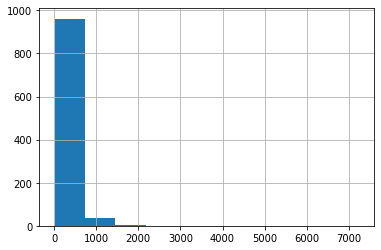

In [11]:
print("斷詞後文章長度: ")
train_data_df['word_count'].hist()

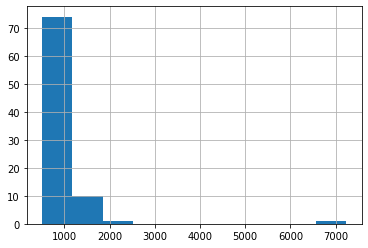

In [12]:
train_data_df[train_data_df['word_count']>500]['word_count'].hist()

各風險則數: 
高風險: 0 則
中風險: 27 則
低風險: 973 則
總共: 1000 則


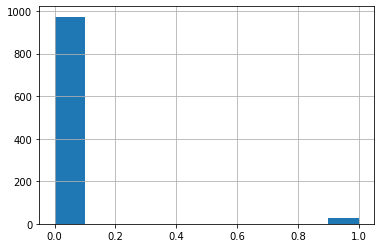

In [13]:
print("各風險則數: ")
train_data_df['class'].hist()

print(f"高風險: {data_df[data_df['Class'] == 2].shape[0]} 則") 
print(f"中風險: {data_df[data_df['Class'] == 1].shape[0]} 則") 
print(f"低風險: {data_df[data_df['Class'] == 0].shape[0]} 則")
print(f"總共: {data_df.shape[0]} 則")

##關鍵字檢查

In [14]:
# 關鍵字檢查
# train_data_df['keyword_flag'], _ = AppendKeywordCheck(train_data_df)
# print(train_data_df.head(5))

# 儲存為pickle格式檔案
with open(data_dir + '/' + 'train_tokenized', 'wb') as file:
    pickle.dump(train_data_df, file)

##製作文字雲

   id                                           sentence  class  word_count
0   0  [牽手, 寶貝, 每次, 偷, 牽, 手, 作勢, 咬, 每次, 輕輕, 含住, 弄, 痛,...      0          53
1   1  [外公, 肺癌, 越發, 嚴重, 關係, 長期, 住, 醫院, 發病, 治療, 經歷, 兩年...      0         171
2   2  [最近, 心情, 情真, 很糟, 習慣, 少, 面對, 親人, 生離, 生離死別, 死別, ...      0         154
3   3  [有時, 有時候, uber, 熊貓, 嚇人, 熊貓, 外, 送, 員, 89, 奇葩, 熊...      0         114
4   4  [好幾, 幾次, 輕生, 想法, 離開, 方式, 浪費, 社會, 資源, 憂鬱, 憂鬱症, ...      1          56
低風險文字雲:


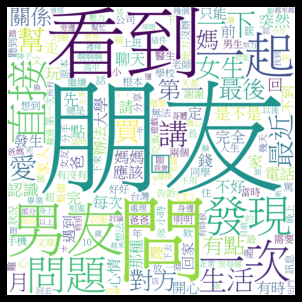

中風險文字雲:


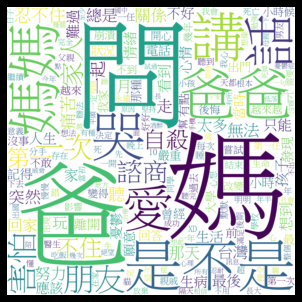

高風險文字雲:


ValueError: ignored

In [ ]:
from OpenFabLibrary import ShowWordCloud

with open(data_dir + '/' + 'train_tokenized', 'rb') as file:
    train_tokenized_df = pickle.load(file)
print(train_tokenized_df.head())
ShowWordCloud(train_tokenized_df)

##Save the processed data

In [15]:
with open(data_dir + '/' + 'train_tokenized', 'rb') as file:
    train_tokenized_df = pickle.load(file)

corpus_source = train_tokenized_df['sentence']
print(corpus_source)

0      [從小, 就, 不, 喜歡, 牽手, 的, 寶貝, 每次, 只要, 一, 偷, 牽, 妳, ...
1      [外公, 因, 為, 肺癌, 越發, 嚴重, 的, 關係, 長期, 住, 在, 醫院, 從,...
2      [最近, 心情, 情真, 真的, 很糟, 可能, 習慣, 了, 但, 也, 覺得, 少, 了...
3      [有時, 有時候, 時候, 叫, uber, 結果, 給, 我, 來, 熊貓, 真的, 很,...
4      [好幾, 幾次, 有, 輕生, 的, 想法, 但, 不, 希望, 自己, 離開, 的, 方式...
                             ...                        
995    [不知, 知道, 該, 發, 哪, 一, 版, 如果, 有違, 違規, 我, 在, 更改, ...
996    [現在, 男生, 生在, 生氣, 了, 但是, 可能, 也, 是, 因, 為, 別的, 事情...
997    [在, 推薦, 上, 看到, 這, 篇文章, 文章, 引起, 我, 的, 興趣, ω, 我,...
998    [ATcqQiw, v2, videos, a38469a8, 687c, 4c55, b3...
999    [我會, 拿到, 一張, 獎狀, 是, 因, 為, 我, 一直, 以來, 都, 很, 努力,...
Name: sentence, Length: 1000, dtype: object


##設定Word2Vec參數並訓練詞向量

In [ ]:
WORD2VEC_DIMENTION = 128
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

def TrainWord2VecModel(input_corpus):
    # build word2vec
    # sg=0 CBOW ; sg=1 skip-gram
    model = word2vec.Word2Vec(size=WORD2VEC_DIMENTION, min_count=5, window=5, sg=0)

    # build vocabulary
    model.build_vocab(input_corpus)

    # train word2vec model ; shuffle data every epoch
    for i in range(40):
        print("%d-th training" % (i))
        random.shuffle(input_corpus)
        model.train(input_corpus, total_examples=len(input_corpus), epochs=1)

    ## save model
    model.save('word2vec_model/CBOW')

In [ ]:
# 若要用已經訓練好的詞向量，這一步可以不做
# 若要訓練新的詞向量，把註解拿掉
# 現階段使用pre-trained mode zh, 300d, 50101 words
TrainWord2VecModel(corpus_source)

In [ ]:
w2v = word2vec.Word2Vec.load('word2vec_model/CBOW')  # 載入剛剛訓練好的Word2Vec model

test_word = '想死'

print(f"'{test_word}'字詞相似度: ")
#print(w2v.wv[test_word])
w2v.wv.most_similar(test_word)

2020-07-09 05:47:01,294: INFO: loading Word2Vec object from word2vec_model/CBOW
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-07-09 05:47:01,336: INFO: loading wv recursively from word2vec_model/CBOW.wv.* with mmap=None
2020-07-09 05:47:01,337: INFO: setting ignored attribute vectors_norm to None
2020-07-09 05:47:01,338: INFO: loading vocabulary recursively from word2vec_model/CBOW.vocabulary.* with mmap=None
2020-07-09 05:47:01,340: INFO: loading trainables recursively from word2vec_model/CBOW.trainables.* with mmap=None
2020-07-09 05:47:01,343: INFO: setting ignored attribute cum_table to None
2020-07-09 05:47:01,345: INFO: loaded word2vec_model/CBOW
2020-07-09 05:47:01,358: I

'想死'字詞相似度: 


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('死掉', 0.7651195526123047),
 ('願望', 0.6770889163017273),
 ('該死', 0.6549395322799683),
 ('鏡', 0.6224474906921387),
 ('看不起', 0.6147435903549194),
 ('念頭', 0.6017012596130371),
 ('不是故意', 0.5947930812835693),
 ('疼', 0.5865309834480286),
 ('五月', 0.5849170088768005),
 ('地獄', 0.5789046287536621)]

In [ ]:
# 列印出訓練好的詞向量
print("詞向量維度:", w2v.wv.vectors.shape)
fo = open("./word2vec.txt", "w+")
for index, vector in enumerate(w2v.wv.vectors):
    #print(vector)
    fo.write(str(vector))
fo.close()

詞向量維度: (4172, 128)


#Train model

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from OpenFabLibrary import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
train_data_source = 'train_tokenized'

trunc_type='post'
padding_type='pre' #'pre'
oov_tok = "<OOV>"
#vocab_size = 50000
max_length = 1024 # 選取多少詞來當作輸入 Ex:選前面40個詞當作輸入

VALIDATION_RATIO = 0.1

WORD2VEC_DIMENTION = 512 #512 300 128 100

##Load dataset

In [44]:
# load article tokenized
with open(data_dir + "/" + train_data_source, 'rb') as file:
    article_df = pickle.load(file)

print(article_df.head(5))

print("#"*100)
print(f"高風險: {article_df[article_df['class'] == 2].shape[0]} 則") 
print(f"中風險: {article_df[article_df['class'] == 1].shape[0]} 則") 
print(f"低風險: {article_df[article_df['class'] == 0].shape[0]} 則")
print(f"總共: {article_df.shape[0]} 則")

   id                                           sentence  class  word_count
0   0  [從小, 就, 不, 喜歡, 牽手, 的, 寶貝, 每次, 只要, 一, 偷, 牽, 妳, ...      0         114
1   1  [外公, 因, 為, 肺癌, 越發, 嚴重, 的, 關係, 長期, 住, 在, 醫院, 從,...      0         302
2   2  [最近, 心情, 情真, 真的, 很糟, 可能, 習慣, 了, 但, 也, 覺得, 少, 了...      0         281
3   3  [有時, 有時候, 時候, 叫, uber, 結果, 給, 我, 來, 熊貓, 真的, 很,...      0         219
4   4  [好幾, 幾次, 有, 輕生, 的, 想法, 但, 不, 希望, 自己, 離開, 的, 方式...      1          99
####################################################################################################
高風險: 0 則
中風險: 27 則
低風險: 973 則
總共: 1000 則


In [45]:
#turn sentence and label into [['甲 乙 丙 丁', label], [,]....]
corpus = process_df(article_df)
print(f"total cases: {len(corpus)}")
print(corpus)

total cases: 1000
[['從小 就 不 喜歡 牽手 的 寶貝 每次 只要 一 偷 牽 妳 的 手 妳 就 會 作勢 要 咬 我 但 每次 都 是 輕輕 含住 不會 弄 痛 我 昨天 終於 牽到 妳 的 手 了 ！！ 妳 的 腳掌 好 大好 可愛 o4pLCKc 這次 妳 沒 把 我 的 手 甩開 是 因 為 妳 沒 力氣 甩開 愛 鬧 妳 的 我 昨天 第一 第一次 一次 牽 妳 的 手 好久 好久好久 好久 但 也 是 最後 一次 了 �� 陪伴 我 目前 前人 人生 一半 以上 的 時間 現在 安穩 的 去 當 小天使 天使 了 妳 真的 很棒 很 勇敢 ！！！ 我 真的 好 愛好 愛 妳', 0], ['外公 因 為 肺癌 越發 嚴重 的 關係 長期 住 在 醫院 從 發病 到 治療 大概 經歷 了 兩年 多 其中 中時 時好時壞 好時壞 好 的 時候 能 在 醫院 院外 外頭 的 公園 散散 散散步 散步 壞 的 時候 連 吞嚥 都 是 折磨 又 因 長期 的 治療 導致 外公 神智 神智不清 甚至 不堪 病魔 的 侵擾 而 著 魔 似的 叫喊 著 老天 讓 他 離開 想起 我 小時 小時候 時候 是 如何 被 外公 捧 在手 手心 的 疼愛 就 不禁 潸然 潸然淚下 雖 使用 大量 藥物 止痛 和 延緩 生命 但 看 著 外公 慘淡 蒼白 的 面容 使 我心 心中 總是 是非 非常 矛盾 期望 他 能 安然 安然無恙 無恙 能 戰勝 病魔 但 又 認 為 與其 痛苦 的 苟延殘喘 殘喘 不如 讓 外公 的 最後 一程 走 得 更 有 尊嚴 無奈 台灣 的 法律 對於 於安樂 安樂 安樂死 樂死 可說 可說是 安樂 安樂死 樂死 一直 都 有 很大 的 爭議 從 生命 價值 優先 的 立場 出發 發人 只要 活 著 不管 機會 多 渺茫 都 不應 放棄 任何 希望 但 也 有人 覺得 安樂 安樂死 樂死 死會 給 一些 不 願 扶養 養老 老人 的 子女 開 了 方便 方便之門 之門 在 國外 每天 幾乎 都 有 病人 提出 提出申請 申請 請安 安樂 安樂死 樂死 想 被 安樂 安樂死 樂死 的 病人 視 其 為 有 質量 尊嚴 的 結束 生命 是 得到 解脫 的 唯一 一方 方法 且 過於 長期 的 治療 時間 讓 病人 毫無 自由 甚至

##Split into training and validation dataset

In [54]:
sentences_train=[]
labels_train=[]

random.seed(109) # 109 108
random.shuffle(corpus)

training_size = int(len(corpus) * (1-VALIDATION_RATIO))

for x in range(training_size):
    sentences_train.append(corpus[x][0])
    labels_train.append(corpus[x][1])

tokenizer = Tokenizer(oov_token=oov_tok) #num_words = vocab_size
tokenizer.fit_on_texts(sentences_train)

print(f"training data: {len(sentences_train)}")

print(sentences_train[:10])
print(labels_train[:10])

training data: 900
['這 是 我們 圖文 創作 的 粉 專 instagram chuyun hh instagram lin du 之前 就 一直 很 想去 寫生 今年 年關 關在 台灣 終於 和 朋友 一起 踏出 這 一步 艸 算了 算了算 時間 我們 是 趁 著 夏天 還有 很多 陽光 的 時候 坐車 坐車到 山區 因 為 看中 這邊 的 蕨類 這次 寫生 我們 就 選 了 坪林 雖然 在 現場 真的 畫 得 很快 快樂 坪林 的 魚 蕨 步道 真的 很 清幽 很美 大 推 但 其實 實在 現場 打稿 到 後續 回家 完成 圖面 面上 的 細節 遇到 超 多 困難 光線 每 分 每秒 都 在 變幻 c7LqQno 2o2vPrf 而且 回家 後 想要 細 修 才 發現 手機 根本 照 不出 樹葉 和 水流 的 感覺 XD 如果 版 上有 寫生 經驗 的 大大 求取 取材 完稿 經驗 分享 >< 又 再經 經過 五六 五六次 六次 的 坪林 一日 一日遊 後 老街 的 伯伯 都 認識 我們 我們 才 陸續 續完 完成 我們 的 寫生 插畫 畫作 作品 並且 做成 了 畫 卡 L5zfamk zBxlB8c 後來 我們 幸運 幸運地 找到 願意 幫 我們 印刷 的 廠商 進一步 一步 地 做 了 帆布 帆布袋 布袋 v *) xoUzPMa YPc6fbH 雖然 我們 都 覺得 作品 還有 進步 的 空間 但 看到 一步 一步 寫生 的 作品 慢慢 成形 真的 是 內心 激動 五百 百遍 而且 抱 著 試試 試試看 試看 的 心情 去 報名 了 市集 攤位 竟然 成功 了 （！！！ 這個 寫生 生活 活動 進行 到 現在 也 已經 三個 月 了 驚 連 坪林 的 溪水 都 變了樣 樣子 應該 該是 漲潮 雖然 最近 近因 為 天氣 的 關係 都 有點 沒辦 辦法 繼續 續寫 寫生 但 最近 近年 年底 了 感慨 的 心情 大 爆發 （？ 於是 就 抱 著 感恩 的 心想 想要 和 大家 分享 這個 創作 的 過程 p s 哦 對了 我們 還 延伸 伸出 了 森林 似 顏 繪 這邊 放 太多 圖 怕 大家 滑 不 完 如果 有 有 興趣 的 大大 也 可以 以來 跟 我們 交流 寫生 生過 過程 ㄛ', '除了 無奈 還是 無奈 看 著 組員 整

In [55]:
sentences_val=[]
labels_val=[]
#validation_size = len(corpus) - training_size
for x in range(training_size, len(corpus)):
    sentences_val.append(corpus[x][0])
    labels_val.append(corpus[x][1])

print(f"validation data: {len(sentences_val)}")

print(sentences_val[:5])
print(labels_val[:5])

print("#"*100)
print("high risk train: ",np.sum(np.array(labels_train)==2))
print("medium risk train: ",np.sum(np.array(labels_train)==1))
print("low risk train: ",np.sum(np.array(labels_train)==0))

print("high risk val: ",np.sum(np.array(labels_val)==2))
print("medium risk val: ",np.sum(np.array(labels_val)==1))
print("low risk val: ",np.sum(np.array(labels_val)==0))

validation data: 100
['前 陣子 因 為 想 說 去 男友 家住 出門 比較 方便 本人 還 沒 考 機車 車駕 駕照 又 可以 長時間 時間 在 一起 的 原因 就 不住 住宿 一段 一段時間 段時間 時間 了 但 室友 A 每次 我 只要 一回 回去 的 時候 就 會 一直 直說 每次 都 不 回來 你 要 不要 乾脆 別 住 了 啊 這種 話 雖然 當下 不以 為 意 畢竟 一開 開始 算是 其他 室友 中 最先 先聊 聊得 開 的 也 把 他 當成 朋友 可能 只是 講話 比較 直接 這樣 ）， 但 事後 想起 起來 就 覺得 是 在 酸 我 還是 在 開玩笑 玩笑 不知 知道 他 對 我 是 什麼 想法 之後 互動 就 很 正常 所以 也 沒 特別 去 追問 上個 上個月 因 為 發生 一些 事情 不住 男友 家 的 當天 原本 看 A 躺平 要 睡 了 結果 突然 爬起 爬起來 起來 跟 我 說 了 一些 話 內容 大致 上 是 啊 你 就 這樣 不 回去 跟 男友 住 喔 如果 要 去 男友 家 的話 可以 點名 完 偷跑 跑出去 出去 點名 的 時候 幫 你 cover 講完 之後 倒頭 就 睡 對於 之前 他 跟 我 說 的 那句話 完全 不 懂 現在 說 這些 話 的 用意 到底 是 要 幫 我 還是 要害 我 ��（ BTW 室友 A 是 連 那種 種別 別人 跟 他 借 課本 借 零錢 不管 不管怎樣 怎樣 都 拒絕 的 人 突然 會 說 要 幫 我 真的 超 怕 �） 但 也 不是 不能 理解 有人 的 習慣 真的 就 不想 那 就 另當別論 別論 但 他 是 也 會 跟 別人 借 東西 的 那種 曾經 被 我 發現 拿走 我 的 豆腐 頭 去 充電 沒 還 我 把 他 自己 的 襪子 丟到 我 放 東西 的 盆子 裡 � 雖然 跟 他 說 的 當下 沒有 到 很嚴 嚴肅 脾氣 很 差 但 好歹 我 也 是 當下 下有 表明 我 很傻 傻眼 順便 也 把 他 的 東西 拿給 他 被 正面 發現 現在 靠北 我 是 因 為 洗完 澡 一出 出來 他 說 什麼 喔 你 裸體 走出 出來 很 噁心 欸 不過 當下 我 也 沒什麼 什麼 要 跟 他 解釋 因 為 我 衣服 忘 了 拿 我 就 穿著 褲子 直接 接上 上半 上半

## Upsample high risk data (only for training dataset)

In [56]:
sentences_train_1 = []
labels_train_1 =[]

for i,l in enumerate(labels_train):
  if l == 1:
    sentences_train_1.append(sentences_train[i])
    labels_train_1.append(labels_train[i])

for i in range(int(876/24 - 1)): # large train / small train
  sentences_train = sentences_train + sentences_train_1
  labels_train = labels_train + labels_train_1

print("#"*100)
print("high risk train: ",np.sum(np.array(labels_train)==2))
print("medium risk train: ",np.sum(np.array(labels_train)==1))
print("low risk train: ",np.sum(np.array(labels_train)==0))

print("high risk val: ",np.sum(np.array(labels_val)==2))
print("medium risk val: ",np.sum(np.array(labels_val)==1))
print("low risk val: ",np.sum(np.array(labels_val)==0))

####################################################################################################
high risk train:  0
medium risk train:  864
low risk train:  876
high risk val:  0
medium risk val:  3
low risk val:  97


##Check the tokenizer

In [57]:
word_index = tokenizer.word_index
vocab_size = len(word_index)
index_word = tokenizer.index_word

print(f'vocab size is: {vocab_size}')
print(word_index)
#print(index_word[4786])

vocab size is: 17753
{'<OOV>': 1, '我': 2, '的': 3, '了': 4, '是': 5, '他': 6, '也': 7, '在': 8, '就': 9, '都': 10, '為': 11, '有': 12, '說': 13, '很': 14, '跟': 15, '會': 16, '你': 17, '自己': 18, '要': 19, '但': 20, '想': 21, '沒有': 22, '真的': 23, '什麼': 24, '不': 25, '覺得': 26, '人': 27, '因': 28, '她': 29, '好': 30, '知道': 31, '一個': 32, '被': 33, '去': 34, '著': 35, '我們': 36, '還': 37, '朋友': 38, '這': 39, '到': 40, '不是': 41, '嗎': 42, '又': 43, '可以': 44, '時候': 45, '沒': 46, '裡': 47, '這樣': 48, '還是': 49, '他們': 50, '看': 51, '做': 52, '所以': 53, '就是': 54, '怎麼': 55, '讓': 56, '一直': 57, '過': 58, '對': 59, '不知': 60, '現在': 61, '給': 62, '才': 63, '然後': 64, '大家': 65, '開始': 66, '那': 67, '不會': 68, '把': 69, '個': 70, '問': 71, '和': 72, '能': 73, '看到': 74, '工作': 75, '如果': 76, '上': 77, '只是': 78, '吧': 79, '找': 80, '一起': 81, '但是': 82, '不要': 83, '多': 84, '後': 85, '啊': 86, '感覺': 87, '事': 88, '已經': 89, '很多': 90, '一次': 91, '可能': 92, '男友': 93, '這個': 94, '有人': 95, '妳': 96, '再': 97, '喜歡': 98, '時間': 99, '一樣': 100, '吃': 101, '個人': 102, '事情': 103, '而且': 1

##Sentence to sequence transform

In [58]:
sequences_train = tokenizer.texts_to_sequences(sentences_train)
padded_train = pad_sequences(sequences_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)

sequences_val = tokenizer.texts_to_sequences(sentences_val)
padded_val = pad_sequences(sequences_val, maxlen=max_length, padding=padding_type, truncating=trunc_type)

labels_train = np.array(labels_train)
labels_val = np.array(labels_val)

print(padded_val)
print(labels_val)

[[   0    0    0 ...   40  111    1]
 [   0    0    0 ...    3  257  244]
 [   0    0    0 ...  314   42  244]
 ...
 [   0    0    0 ...  321   79 1348]
 [   0    0    0 ...  203    5   48]
 [   0    0    0 ...  193   42  892]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


##Load pre-trained w2v, create word ID mapping and word vector

### Kevin

In [ ]:
#w2v = word2vec.Word2Vec.load('word2vec_model/CBOW')
w2v = word2vec.Word2Vec.load('word2vec_model/zh.bin')
word2id = {k:i for i, k in enumerate(w2v.wv.vocab.keys())}
id2word = {i:k for k, i in word2id.items()}
#print(word2id)
word2id_len = len(word2id)
print('word2id_len:', word2id_len)
print('the last word is:', id2word[word2id_len-1])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


word2id_len: 50101
the last word is: 戰期間


In [ ]:
# print("詞向量維度:", w2v.wv.vectors.shape)
# test_word = '自殺'
# print(f"'{test_word}'字詞相似度: ")
# #print(w2v.wv[test_word])
# w2v.wv.most_similar(test_word)

In [ ]:
embeddings_matrix = np.zeros((vocab_size + 1, WORD2VEC_DIMENTION)) # +1 because index_word index starts from 1
for word, i in word_index.items():
  if word in word2id:
    embedding_vector = w2v.wv[word]
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print(embeddings_matrix.shape)
print(embeddings_matrix)

(18418, 300)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.2249358  -0.96961224  0.70858282 ... -0.19811729  0.16071561
  -0.15473877]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


### 科技大擂台
https://github.com/ysj-sp/jin-jin-ti-generator/blob/master/training.py  
https://fgc.stpi.narl.org.tw/activity/videoDetail/4b1141305ddf5522015de5479f4701b1

In [59]:
# Get word vector
dim = 0
word_vecs = {}
with open('word2vec_model/cna.cbow.512d.0.txt') as f:
    for line in f:
        tokens = line.strip().split()

        if len(tokens) == 2:
            dim = int(tokens[1])
            continue

        word = tokens[0]
        vec = np.array([float(t) for t in tokens[1:]])
        word_vecs[word] = vec

In [60]:
print("total words in the pre-trained w2v:", len(word_vecs))
print("dimension: ",len(word_vecs['想要']))
print(word_vecs.get('想死', None))

total words in the pre-trained w2v: 158566
dimension:  512
None


In [61]:
embeddings_matrix = np.zeros((vocab_size + 1, WORD2VEC_DIMENTION)) # +1 because index_word index starts from 1
for word, i in word_index.items():
  if word in word_vecs:
    embedding_vector = word_vecs[word]
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print(embeddings_matrix.shape)
print(embeddings_matrix)

(17754, 512)
[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [-0.573659  0.50332  -1.541493 ...  0.602698 -0.240994 -0.80224 ]
 ...
 [-0.278319 -0.490743  0.518557 ... -0.666658 -0.574852  0.052399]
 [ 0.420835  0.318346  1.748015 ...  0.139922 -0.22763  -1.881082]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


##Create LSTM model

In [90]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, WORD2VEC_DIMENTION, input_length=max_length, weights=[embeddings_matrix], trainable=False), #trainable=False
    # tf.keras.layers.Embedding(vocab_size + 1, 16, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # 64, 32
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),  #6, 8
    tf.keras.layers.Dense(1, activation='sigmoid') #3 softmax
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',tf.keras.metrics.AUC(name='auc')]) #sparse_categorical_crossentropy
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1024, 512)         9090048   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 1024, 128)         295424    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 9,427,745
Trainable params: 337,697
Non-trainable params: 9,090,048
______________________________________

https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC

##Set callback and class_weight

In [91]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.96):
      print("\nReached 96% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                             verbose=1, mode='auto', restore_best_weights=False) # True

In [92]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(labels_train), labels_train)
print(class_weights)

[0.99315068 1.00694444]


##Train the model

In [93]:
BATCH_SIZE = 8
NUM_EPOCHS = 14

history = model.fit(padded_train, labels_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                    validation_data=(padded_val, labels_val),callbacks=[earlystop]
                    , class_weight={0:class_weights[0], 1:class_weights[1]}) #, class_weight={0:class_weights[0], 1:class_weights[1], 2:class_weights[2]}

Epoch 1/14
218/218 [==============================] - 35s 134ms/step - loss: 0.4004 - accuracy: 0.8029 - auc: 0.8958 - val_loss: 0.1858 - val_accuracy: 0.9700 - val_auc: 0.4897
Epoch 2/14
218/218 [==============================] - 28s 127ms/step - loss: 0.0092 - accuracy: 0.9984 - auc: 0.9999 - val_loss: 0.1947 - val_accuracy: 0.9700 - val_auc: 0.6460
Epoch 3/14
218/218 [==============================] - 28s 127ms/step - loss: 0.0108 - accuracy: 0.9977 - auc: 0.9993 - val_loss: 0.1908 - val_accuracy: 0.9600 - val_auc: 0.6598
Epoch 4/14
218/218 [==============================] - 28s 127ms/step - loss: 0.0045 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2009 - val_accuracy: 0.9700 - val_auc: 0.6598
Epoch 5/14
218/218 [==============================] - 28s 126ms/step - loss: 0.0012 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2092 - val_accuracy: 0.9700 - val_auc: 0.6598
Epoch 6/14
218/218 [==============================] - 28s 127ms/step - loss: 6.4005e-04 - accuracy: 1.0000 - auc: 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the entire model as a SavedModel.
model.save('../drive/My Drive/Colab data/suicide_model_2_classes.h5')

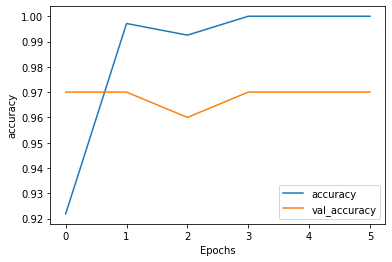

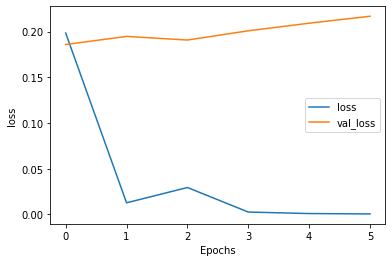

In [94]:
%matplotlib inline

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#See Validation Confusion Matrix

In [ ]:
# Load model
# model = tf.keras.models.load_model('suicide_model_2_classes.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix, without normalization
[[97  0]
 [ 3  0]]


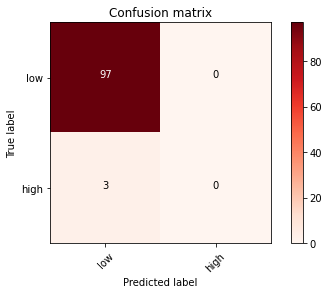

In [95]:
result = model.predict_classes(padded_val)
# print("all predicted result:", result)
cm = confusion_matrix(labels_val, result)
cm_plot_labels = ['low', 'high'] # ['low', 'medium', 'high']
plot_confusion_matrix(cm, cm_plot_labels)

In [96]:
TP = cm[1][1]
FP = cm[0][1]
TN = cm[0][0]
FN = cm[1][0]

print("Sensitivity:", round(TP/(TP+FN),3))
print("Specificity:", round(TN/(FP+TN),3))
print("Precision:", round(TP/(TP+FP),3))
print("Recall:", round(TP/(TP+FN),3))

Sensitivity: 0.0
Specificity: 1.0
Precision: nan
Recall: 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


#Test the model

single input  

In [ ]:
# input_text = "習慣了。現在漸漸地變成了一個常態只是後續要處理好自己還是人類部分的情感需求要漸漸地漸漸地習慣讓這部分死去直到我完全的成為了活屍我就成功了對她人最安全的做法就是我完全的不在對方的世界裏我也完全的不說話認識一個人。馬上把她刪好友是對對方最好的做法也是對我最好的做法沒有接觸。沒有期待 沒有傷害快樂是別人的 我什麼都沒有如果＊我＊的這概念也消失了那我就連這段話都感覺不到了這是我的目標成為一具屍體。也不知道賺錢做什麼我覺得世界是一座巨大的墳墓一切都在腐爛我是具有溫度的屍體感覺可以死了。可是又好像跟死了差不多說出這句話竟有種矛盾的感覺反正也離死不遠了--"
# ad_Class = 2
# ad_ID = 0
# ad_Description = input_text

# test_data_df = pd.DataFrame({'ID': [ad_ID], 
#                             'Description':[ad_Description],
#                             'Class':[ad_Class]})
# print(test_data_df)

multiple inputs

In [ ]:
#用記事本打開csv文件，另存為设置編碼為utf-8
test_data_source = "test_data_0817.csv"
test_data_df = pd.read_csv(data_dir + '/' + test_data_source, encoding='utf8', delimiter=',')
print(test_data_df.head())

   ID                                        Description  Class
0   0  - - - - - - - - - - - - - -附錄：【發文與推文罰則】- - - -...    NaN
1   1                     --　　　　　　　　　　　　　　　　　　　　　    　--    NaN
2   2  版友們有哪些討厭的副作用呢？今天去運動途中哭了因為副作用讓我覺得沒辦法掌控自己的身體很痛苦 ...    NaN
3   3  「我會在，你放心。我們就慢慢把環境適應。」治療的最後，L說著，想要安撫我下週工作室搬遷的焦慮...    NaN
4   4  其實我也不知道在焦慮甚麼也許是不想有人來管吧?本來是社區自聘的管理員6/1起外包給保全公司我...    NaN


In [ ]:
# 斷詞處理
test_df = JeibaCutWords(test_data_df, "Description")
print(test_df)
# 關鍵字檢查
#test_df['keyword_flag'], keywords_list = AppendKeywordCheck(test_df)

#extract all sentences
test_corpus = process_df(test_df)
print(f"total cases: {len(test_corpus)}")
print(test_corpus)

sentences_test=[]
labels_test=[]
for x in range(len(test_corpus)):
    sentences_test.append(test_corpus[x][0])
    labels_test.append(test_corpus[x][1])

print(f"test data: {len(sentences_test)}")

sequences_test = tokenizer.texts_to_sequences(sentences_test)
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#print(sequences_test)
#print(padded_test)

# probability = model.predict(padded_test)
# print(probability[0])
result = model.predict_classes(padded_test)
print(result)

Building prefix dict from /content/suicide_multiclass/Jeiba/dict.txt.big ...
Loading model from cache /tmp/jieba.ucb66ba17c4739edbeb5fb122bb3a9bb9.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


      id                                           sentence  class
0      0  [附錄, ：【, 發文, 推, 文, 罰則, 第一, 第一條, 一條, 凡未, 未分, 未分...    NaN
1      1                                                 []    NaN
2      2  [版友, 討厭, 副作用, 作用, 運動, 途中, 哭, 副作用, 作用, 沒辦, 辦法, ...    NaN
3      3  [我會, 放心, 慢慢, 環境, 適應, 。」, 治療, 最後, L, 安撫, 下週, 工作...    NaN
4      4  [焦慮, 想有, 本來, 社區, 聘, 管理, 管理員, 外包, 包給, 保全, 保全公司,...    NaN
..   ...                                                ...    ...
195  195  [篇, 分類, 醫療, 陰天, 應該, 陰天, 主, 再上, 上禮, 禮拜, 朋友, dc,...    NaN
196  196  [倒楣, 住, 住家, 開放, 開放式, 小巷, 小巷子, 巷子, 一群, 三姑, 三姑六婆...    NaN
197  197  [超級, 懶洋洋, 洋洋, 一早, 進行, 喝咖啡, 咖啡, 儀式, 感, 嘴巴, 吃藥, ...    NaN
198  198  [吞, 幾排, 藥, 至少, 留下, 傷痕, 死, 胖, 藥效, 發作, 前, 總是, 不覺...    NaN
199  199  [糟糕, 教練, 課, 體重, 體脂, 不像樣, 像樣, 作息, 不正, 正常, 睡覺, 睡...    NaN

[200 rows x 3 columns]
total cases: 200
[['附錄 ：【 發文 推 文 罰則 第一 第一條 一條 凡未 未分 未分類 分類 自創 分類 未滿 20 字 不含 標點 標點符號 符號 文章 含有 自殺 自殘 OD 相關 關內 內容 未在 標題 加註 雷 雷 初犯 板 主將 直接 刪除 文章 外公 公告 通知 後發 發文 推 文 仍未 未改 改善 善者 

In [ ]:
test_data_df['Predicted'] = result
test_data_df.to_csv(data_dir + '/suicide_test_result.csv', encoding='utf8')

In [ ]:
# if np.argmax(probability) == 2:
#   print("辨識結果: 高風險")
# elif np.argmax(probability) == 1:
#   print("辨識結果: 中風險")
# elif np.argmax(probability) == 0:
#   print("辨識結果: 低風險")

# print("判斷機率: ", probability[0][np.argmax(probability)])
# #print("違規字詞: ", keywords_list)

In [ ]:
cm = confusion_matrix(labels_test, result)
cm_plot_labels = ['low', 'medium', 'high'] #['low', 'medium', 'high']
plot_confusion_matrix(cm, cm_plot_labels)